# Nonlinear elastic isotropic wave-equation operator

@Author: Ettore Biondi - ebiondi@caltech.edu

In this notebook we will model some elastic data by solving the elastic isotropic wave equation in 2D using GPU-based staggered-grid finite-difference operators ([Virieux,1986](https://library.seg.org/doi/abs/10.1190/1.1442147)).

## Import modules

In [1]:
# Importing necessary modules
import os
import genericIO
import numpy as np
# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

## Marmousi 2D elastic model

We will be model data on the Marmousi2 model. Let's plot the three elastic parameters.

In [2]:
# Reading Marmousi model as a vector
MarmEla = genericIO.defaultIO.getVector("MarmVpVsRho.H")
MarmElaNd = MarmEla.getNdArray()
MarmHyper = MarmEla.getHyper()
# Getting axes' information
oz = MarmHyper.getAxis(1).o
dz = MarmHyper.getAxis(1).d
nz = MarmHyper.getAxis(1).n
ox = MarmHyper.getAxis(2).o
dx = MarmHyper.getAxis(2).d
nx = MarmHyper.getAxis(2).n
MarmVp = MarmElaNd[0,:,:]
MarmVs = MarmElaNd[1,:,:]
MarmRho = MarmElaNd[2,:,:]

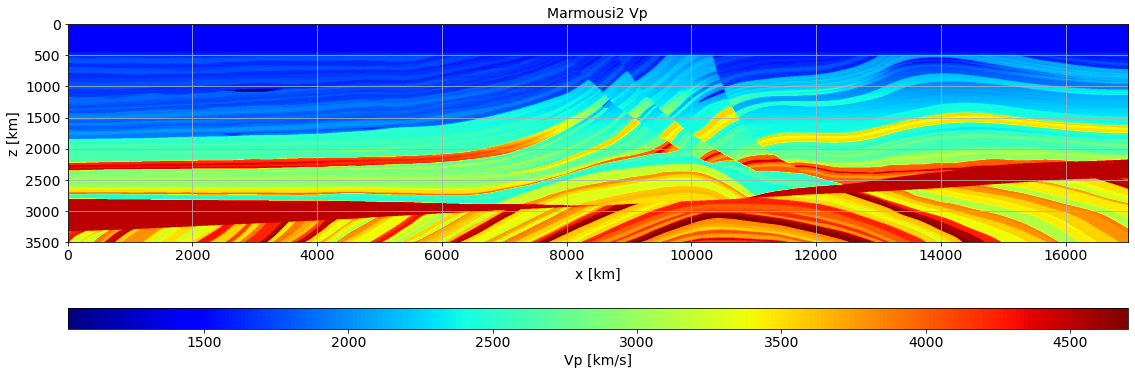

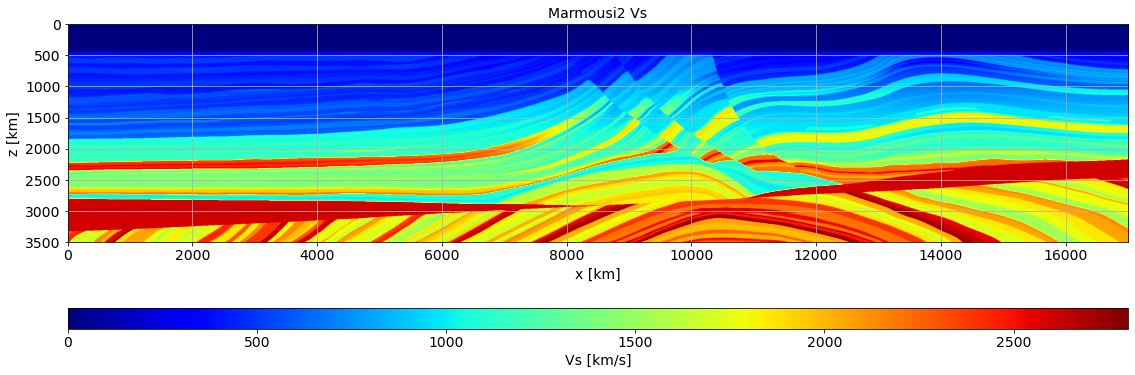

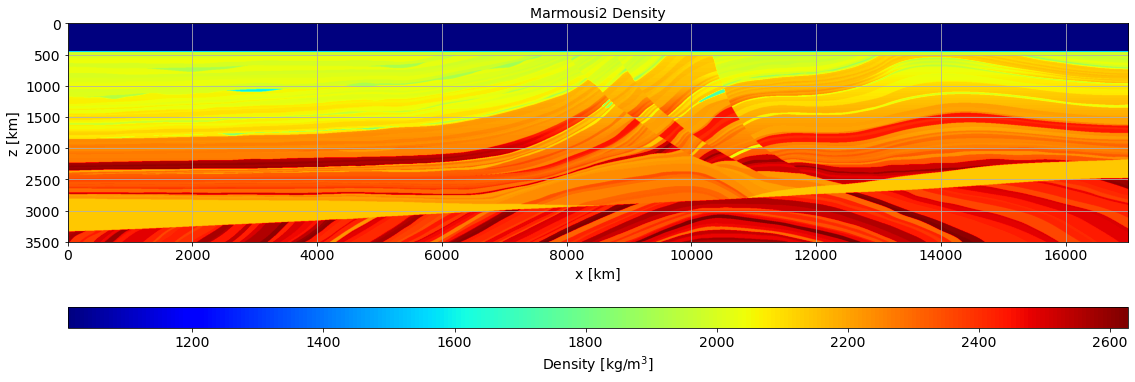

In [15]:
plt.figure(figsize=(19,8))
plt.imshow(MarmVp.T,cmap='jet', vmin=MarmVp.min(), vmax=MarmVp.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Marmousi2 Vp"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="Vp [km/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(MarmVs.T,cmap='jet', vmin=MarmVs.min(), vmax=MarmVs.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Marmousi2 Vs"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="Vs [km/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(MarmRho.T,cmap='jet', vmin=MarmRho.min(), vmax=MarmRho.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Marmousi2 Density"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="Density [kg/m$^3$]", aspect=50)
plt.grid()
plt.show()

Just like any finite-difference modeling code, boundary conditions must be set. In this case, we impose absorbing boundary all around this elastic model. Hence, we pad all the boundaries a buffer absorbing area.

In [4]:
# Pad Marmousi velocity model
!padElasticFileGpuMain zPad=100 xPad=100 model=MarmVpVsRho.H data=MarmVpVsRho.pad.H

 
------------------------ Model padding program --------------------
Chosen surface condition parameter: (0) no free surface condition
Original nz = 701 [samples]
Original nx = 3401 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 111 [samples]
xPadMinus = 100 [samples]
xPadPlus = 115 [samples]
 
blockSize = 16 [samples]
FAT = 4 [samples]
 
New nz = 920 [samples including padding and FAT]
New nx = 3624 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Source signature or wavelet

We are going to use an explosive source. So we will be injecting energy in the normal stress components of the wavefield.

In [14]:
!waveletFloatMain.py timeDelay=1 f1=2 f2=5 f3=8 f4=20 type=ali par=parMarmousi.p wavelet=results/tmpwavelet.H

In [6]:
# Reading the wavelet
wavelet = genericIO.defaultIO.getVector("results/tmpwavelet.H")
waveletNd = wavelet.getNdArray()
waveletHyper = wavelet.getHyper()
timeAxis = waveletHyper.getAxis(1)
nt = timeAxis.n
ot = timeAxis.o
dt = timeAxis.d

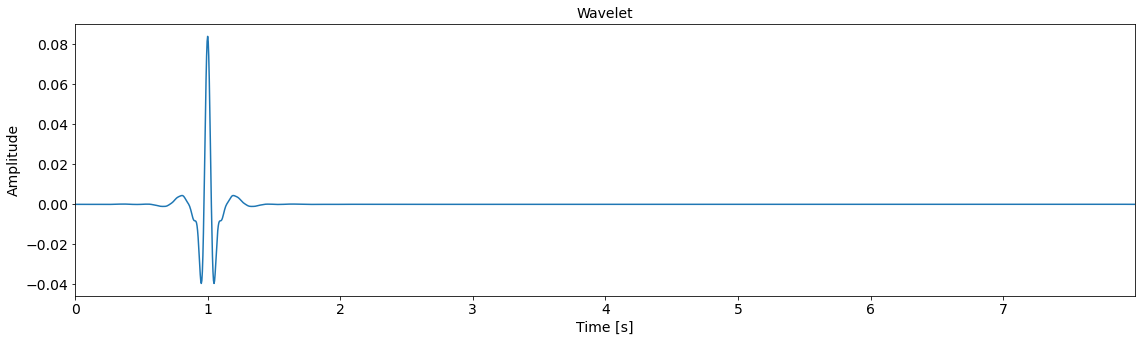

In [7]:
fig,ax=plt.subplots(figsize=(19,5))
time_range = np.linspace(ot,ot+(nt-1)*dt,nt)
plt.plot(np.linspace(ot,ot+(nt-1)*dt,nt), waveletNd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

Let's create the input file to inject such an explosive source with the time signature shown above.

In [8]:
compAxis = genericIO.Hypercube.axis(n=5)
ElaSourceHyper = genericIO.Hypercube.hypercube(axes=[timeAxis,compAxis])
ElaSource = genericIO.SepVector.getSepVector(ElaSourceHyper)
# Setting the correct component of the source to the desired signature
scale=1e11 # To obtain model realistic values from the modeling
ElaSource.zero()
ElaSourceNd = ElaSource.getNdArray()
ElaSourceNd[2,:] = waveletNd*scale
ElaSourceNd[3,:] = waveletNd*scale
ElaSource.writeVec("ElaWavelet.H")

## Nonlinear modeling for generating shot gathers

Let's now run the modeling script and solve the elastic wave equation. All the implemented scripts employ a parameter file that contains the necessary information related to the modeling or inversion considered. Let's print the one associated with this example.

In [9]:
# Printing parameter file for reference
!cat parMarmousi.p

nts=2000  #Number of time samples
dts=0.004 #Coarse sampling [s]
sub=10	  #Ratio between coarse and propagation samplings
nz=920    #Number of samples in the z direction
dz=5      #Sampling of z direction [m]
nx=3624   #Number of samples in the x direction
dx=5      #Sampling of x direction [m]
fMax=16   #Maximum propagated frequency [Hz]
mod_par=1 #Model parameterization (1 = VpVsRho)

#The following numbers are provided when the model is padded
zPadMinus=100               #Number of padding samples on top of the model
zPadPlus=111	            #Number of padding samples on bottom of the model
xPadMinus=100               #Number of padding samples on left of the model
xPadPlus=115                #Number of padding samples on right of the model

#Source geometry
nExp=1                      #Number of shots
zSource=3                   #Shots' depth
xSource=850                 #X position of the first shot
spacingShots=10	            #Shot interval

#Receiver geometry
nReceiver=3401      

By running the program without any input, we can show the program documentation.

In [10]:
!nonlinearPythonElasticFloatMain.py


GPU-based elastic isotropic velocity-stress wave-equation non-linear modeling operator (single-precision version)

USAGE EXAMPLE:
	nonlinearPythonElasticFloatMain.py elasticParam=elasticModel.H model=elastic_wavelet.H par=parNonlinear.p data=elastic_data.H

INPUT PARAMETERS:
	elasticParam = [no default] - string; Header file defining elastic subsurface parameters (z [m], x [m], component [see mod_par]).
	                                      These parameters must be correctly padded using the padElasticFileGpuMain program.

	model = [no default] - string; Header file defining elastic source term (t,component=[fx -> volumetric force along x axis [N/m^3], fz -> volumetric force along z axis [N/m^3],
	                               Sxx -> injection rate within normal xx stress [Pa/s], Szz -> injection rate within normal zz stress [Pa/s],
	                               Sxz -> injection rate within shear xz stress [Pa/s]]).

	data [no default] - string; Header file in which recorded elast

In [11]:
# Running non-linear operator to elastic data
!nonlinearPythonElasticFloatMain.py elasticParam=MarmVpVsRho.pad.H model=ElaWavelet.H par=parMarmousi.p data=results/nonlinear_data.H

 
-------------------------------------------------------------------
---------------------------- INFO FOR GPU# 0 ----------------------
-------------------------------------------------------------------
Number of requested GPUs: 1
Number of available GPUs: 4
Id of requested GPUs: 0
Cuda driver version: 0
Name: Tesla P100-SXM2-16GB
Total global memory: 15 [GB] 
Shared memory per block: 48 [kB]
Number of register per block: 65536
Warp size: 32 [threads]
Maximum pitch allowed for memory copies in bytes: 1 [GB]
Maximum threads per block: 1024
Maximum block dimensions: (1024, 1024, 64)
Maximum grid dimensions: (2147483647, 65535, 65535)
Total constant memory: 64 [kB]
Number of streaming multiprocessors on device: 56
Device can simultaneously perform a cudaMemcpy() and kernel execution
Device can map host memory
Device can support concurrent kernel
-------------------------------------------------------------------
 
-------------------------------------------------------------------
----

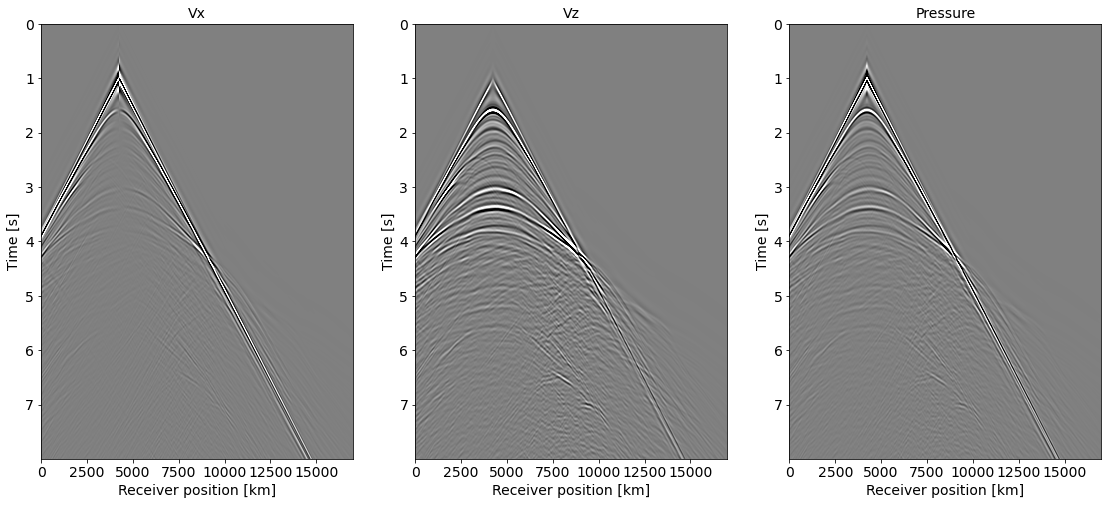

In [12]:
# Plotting the data
dataMarmNd = genericIO.defaultIO.getVector("results/nonlinear_data.H").getNdArray()
Vx = dataMarmNd[0,:,:]
Vz = dataMarmNd[1,:,:]
P = (dataMarmNd[2,:,:] + dataMarmNd[3,:,:])*0.5


plt.figure(figsize=(19,8))

plt.subplot(131), plt.title("Vx")
clipVal = np.percentile(np.absolute(Vx),99.0)
plt.imshow(Vx.T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.subplot(132), plt.title("Vz")
clipVal = np.percentile(np.absolute(Vz),99.0)
plt.imshow(Vz.T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.subplot(133), plt.title("Pressure")
clipVal = np.percentile(np.absolute(P),99.0)
plt.imshow(P.T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.show()

## Dot-product test

Lastly, because we are mostly interested in inverse processes, it is crucial to assess the accuracy of the forward mapping against the adjoint operator. We do this using double-precision operators by running the following command:

In [13]:
# Running dot-product test using double-precision numbers
!nonlinearPythonElasticDoubleMain.py elasticParam=MarmVpVsRho.pad.H model=ElaWavelet.H par=parMarmousi.p data=results/nonlinear_data.H dpTest=1 info=0

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
 Runs in: 79.53579616546631 seconds
Applying adjoint operator add=False
 Runs in: 94.66936159133911 seconds
Dot products add=False: domain=2.480876e-01 range=2.480876e-01 
Absolute error: 3.849698e-14
Relative error: 1.551750e-13 

Applying forward operator add=True
 Runs in: 78.34023451805115 seconds
Applying adjoint operator add=True
 Runs in: 94.38604760169983 seconds
Dot products add=True: domain=4.961752e-01 range=4.961752e-01 
Absolute error: 8.354428e-14
Relative error: 1.683766e-13 

-------------------------------------------------
